# Model
Questo è il modello più semplice, senza training o triplet loss

In [4]:
# Get data ready -> turn it into tensor

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.transforms import ToTensor

# This set the transformation for the ResNet CNN
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Caricare il dataset di training
train_dataset = ImageFolder(root="data_example/train", transform=transform)


# Caricare il dataset di test
## Crea una classe TestImageDataset con cui mappare i dati
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(".jpg")
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

## Mappa due tipi di dati, definisce come caricarli una alla volta e le trasformazioni da applicare
query_dataset = TestImageDataset("data_example/test/query", transform=transform) # Query le immagine usate per chiedere il confronto
gallery_dataset = TestImageDataset("data_example/test/gallery", transform=transform) # Le immagini che verranno confrontate


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.6051416].


ValueError: num must be an integer with 1 <= num <= 4, not 5

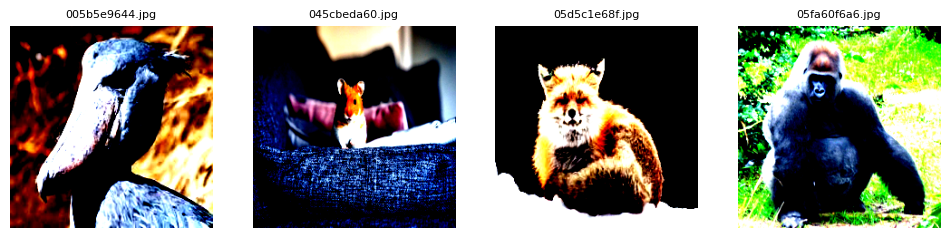

In [6]:
# Cosi possiamo vedere cio che vede ResNet
import matplotlib.pyplot as plt

# Mostra le prime 4 immagini del query_dataset (senza denormalizzare)
plt.figure(figsize=(12, 6))
for i in range(10):
    img_tensor, filename = query_dataset[i]
    img = img_tensor.permute(1, 2, 0)  # [C, H, W] → [H, W, C]

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"{filename}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
# Setting the Dataloader
# We prepeare the data for the ML also setting the first hyperparmeter batch size
batch_size = 32

## Training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Test data
query_loader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False)
gallery_loader = DataLoader(gallery_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Analyze the Dataloader
print(f"Dataloaders: {train_loader, query_loader, gallery_loader }")
print(f"Length of train dataloader: {len(train_loader)} batches of {batch_size}")
print(f"Length of query dataloader: {len(query_loader)} batches of {batch_size}")
print(f"Length of galley dataloader: {len(gallery_loader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x11ff25d30>, <torch.utils.data.dataloader.DataLoader object at 0x14916afd0>, <torch.utils.data.dataloader.DataLoader object at 0x14925b4d0>)
Length of train dataloader: 31 batches of 32
Length of query dataloader: 3 batches of 32
Length of galley dataloader: 121 batches of 32


## Pick a model
In this phase we pick a model to do the embedding


In [9]:
# Usare ResNet-50 come feature extractor (senza il layer finale)
## se lo sati facendo andare da jupyter incolla nel terminale questo
'''
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
print("FUNZIONA!")
'''

from torchvision.models import resnet50, ResNet50_Weights
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
import os
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights


# Carica ResNet-50 con pesi pre-addestrati (ImageNet)
weights = ResNet50_Weights.DEFAULT # Prende i pesi pre addesrati
resnet = resnet50(weights=weights) # Li applica alla resnet

# Rimuovi l'ultimo layer (fc) → ottieni solo la parte convoluzionale
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Output: [B, 2048, 1, 1]


# Wrappa in una rete che restituisce un vettore [B, 2048]
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = feature_extractor # Andiamo ad inserrire i vari layer dentro il modello che abbiamo creato

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)  # Da [B, 2048, 1, 1] a [B, 2048
        return x


# Inizializza modello
model = EmbeddingNet()

# Se hai GPU, spostalo su CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Imposta in modalità eval (senza dropout/batchnorm training)
model.eval()


EmbeddingNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [10]:
# Estraiamo gli embeddign
import torch
from tqdm import tqdm

def extract_embeddings(dataloader, model, device):
    embeddings = []
    filenames = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            images, names = batch
            images = images.to(device)
            embs = model(images)  # [B, 2048]
            embeddings.append(embs.cpu())
            filenames.extend(names)

    embeddings = torch.cat(embeddings, dim=0)  # [N, 2048]
    return embeddings, filenames

query_embeddings, query_filenames = extract_embeddings(query_loader, model, device)
gallery_embeddings, gallery_filenames = extract_embeddings(gallery_loader, model, device)


100%|██████████| 121/121 [04:16<00:00,  2.12s/it]


## Usare il modello


In [11]:
import torch.nn.functional as F

def retrieve_topk(query_embs, gallery_embs, gallery_names, k=5):
    results = {}

    # Normalizza i vettori per cosine similarity (facoltativo per cosine)
    query_embs = F.normalize(query_embs, p=2, dim=1)
    gallery_embs = F.normalize(gallery_embs, p=2, dim=1)

    # Calcola similarità (matrice [n_query, n_gallery])
    similarity = torch.matmul(query_embs, gallery_embs.T)

    # Trova i top-k index
    topk_values, topk_indices = torch.topk(similarity, k=k, dim=1)

    for i, qname in enumerate(query_filenames):
        retrieved_names = [gallery_names[idx] for idx in topk_indices[i]]
        results[qname] = retrieved_names

    return results

topk_results = retrieve_topk(query_embeddings, gallery_embeddings, gallery_filenames, k=5)
topk_results


{'005b5e9644.jpg': ['70b7b8492a.jpg',
  '5e0ff30e62.jpg',
  '51d2630254.jpg',
  '3fc7a4d84b.jpg',
  '2a77fae918.jpg'],
 '045cbeda60.jpg': ['2cbf7685c4.jpg',
  '2e9dd3ccac.jpg',
  '51f56700ba.jpg',
  'a8a9e93caf.jpg',
  '0d21db0c78.jpg'],
 '05d5c1e68f.jpg': ['58e1d5a93e.jpg',
  '41b324a161.jpg',
  '9b77a2be24.jpg',
  '3c1377bd9b.jpg',
  '33faf3477f.jpg'],
 '05fa60f6a6.jpg': ['75c0e82e1b.jpg',
  '1ad709457f.jpg',
  '060d2a2732.jpg',
  '306b36f1b0.jpg',
  '290fd87d45.jpg'],
 '0615c19b25.jpg': ['3efb4f3151.jpg',
  '7aaa3f657b.jpg',
  '58a0e73fa1.jpg',
  '8ca7742d95.jpg',
  '82d357358c.jpg'],
 '067a665d84.jpg': ['5fc76b6be5.jpg',
  '37d5f8a585.jpg',
  '73c812bcd9.jpg',
  '155fc9d6de.jpg',
  '98b24c0c93.jpg'],
 '06ce58dce1.jpg': ['2e91654bef.jpg',
  '1637f05a88.jpg',
  '7be41935d0.jpg',
  '00720a8130.jpg',
  '3d05120fc1.jpg'],
 '06e320f74d.jpg': ['247beaf6bd.jpg',
  '1a4ffd8af3.jpg',
  '3dbd3f4fc9.jpg',
  '9c3db9d85d.jpg',
  '55fd9f9b33.jpg'],
 '072ea20665.jpg': ['5c308a1091.jpg',
  '2b455bb